In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d constantinwerner/human-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset
License(s): CC0-1.0
human-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/human-detection-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [1]:
# =======================
# Cell 1: Create annotations.csv using pretrained COCO model
# =======================
import os
import pandas as pd
import torch, torchvision
from PIL import Image
from torchvision.transforms import functional as F
from tqdm import tqdm

IMG_DIR = "/content/human detection dataset/1"   # folder with positive human images
OUT_CSV = "annotations.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Pretrained Faster R-CNN (COCO)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
model.eval()

rows = []
for fname in tqdm(os.listdir(IMG_DIR), desc="Processing images"):
    path = os.path.join(IMG_DIR, fname)
    if not (fname.lower().endswith(".jpg") or fname.lower().endswith(".png")):
        continue
    img = Image.open(path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)[0]

    for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
        if label.item() == 1 and score.item() > 0.8:  # person class only
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            rows.append([fname, int(xmin), int(ymin), int(xmax), int(ymax), "person"])

df = pd.DataFrame(rows, columns=["filename","xmin","ymin","xmax","ymax","label"])
df.to_csv(OUT_CSV, index=False)
print(f" Saved {len(rows)} bounding boxes to {OUT_CSV}")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 183MB/s]
Processing images: 100%|██████████| 559/559 [01:05<00:00,  8.47it/s]


 Saved 785 bounding boxes to annotations.csv


In [5]:
# =======================
# Cell 2: Train/Val/Test split
# =======================
import random
random.seed(42)

CSV = "annotations.csv"
OUT_DIR = "splits"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV)
file_groups = df.groupby("filename")

pos_files, neg_files = [], []
for fname, g in file_groups:
    if g['xmin'].notnull().any():  # has human box
        pos_files.append(fname)
    else:
        neg_files.append(fname)

def split_list(lst, train_frac=0.7, val_frac=0.2):
    random.shuffle(lst)
    n = len(lst)
    n1 = int(n * train_frac)
    n2 = int(n * val_frac)
    return lst[:n1], lst[n1:n1+n2], lst[n1+n2:]

train_pos, val_pos, test_pos = split_list(pos_files)
train_neg, val_neg, test_neg = split_list(neg_files)

train_files = set(train_pos + train_neg)
val_files = set(val_pos + val_neg)
test_files = set(test_pos + test_neg)

df_train = df[df['filename'].isin(train_files)]
df_val   = df[df['filename'].isin(val_files)]
df_test  = df[df['filename'].isin(test_files)]

df_train.to_csv(os.path.join(OUT_DIR,"train.csv"), index=False)
df_val.to_csv(os.path.join(OUT_DIR,"val.csv"), index=False)
df_test.to_csv(os.path.join(OUT_DIR,"test.csv"), index=False)

print("Train/Val/Test sizes (images):", len(train_files), len(val_files), len(test_files))


Train/Val/Test sizes (images): 337 96 49


In [6]:
# =======================
# Cell 3: Dataset class with augmentation
# =======================
import torchvision.transforms as T

class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_root, train=True):
        self.df = pd.read_csv(csv_path)
        self.img_root = img_root
        self.fnames = self.df['filename'].unique().tolist()
        self.train = train
        self.transform = T.Compose([
            T.RandomHorizontalFlip(0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.ToTensor()
        ]) if train else T.ToTensor()

    def _find_image(self, fname):
        p1 = os.path.join(self.img_root, "1", fname)
        p0 = os.path.join(self.img_root, "0", fname)
        if os.path.exists(p1): return p1
        if os.path.exists(p0): return p0
        return os.path.join(self.img_root, fname)

    def __len__(self): return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = self._find_image(fname)
        img = Image.open(path).convert("RGB")

        rows = self.df[self.df['filename'] == fname]
        boxes, labels = [], []
        for _, r in rows.iterrows():
            if pd.isna(r['xmin']): continue
            boxes.append([r['xmin'], r['ymin'], r['xmax'], r['ymax']])
            labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) else torch.zeros((0,4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels) else torch.zeros((0,), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        img = self.transform(img) if self.train else F.to_tensor(img)
        return img, target

def collate_fn(batch): return tuple(zip(*batch))


In [7]:
# =======================
# Cell 4: Test Dataset
# =======================
ds = CSVDataset("/content/annotations.csv", "/content/human detection dataset", train=True)

print(" Dataset length:", len(ds))
img, target = ds[0]
print(" Image shape:", img.shape)
print(" Target sample:", target)


 Dataset length: 482
 Image shape: torch.Size([3, 256, 256])
 Target sample: {'boxes': tensor([[  9., 115.,  35., 222.]]), 'labels': tensor([1]), 'image_id': tensor([0])}


In [8]:
# =======================
# Cell 5: Model
# =======================
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=2):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Freeze backbone to avoid overfitting
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [9]:
# =======================
# Cell 6: DataLoader
# =======================
from torch.utils.data import DataLoader

train_dataset = CSVDataset("/content/annotations.csv", "/content/human detection dataset", train=True)
val_dataset   = CSVDataset("/content/annotations.csv", "/content/human detection dataset", train=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(" Train batches:", len(train_loader))
print(" Val batches:", len(val_loader))

# Check one batch
imgs, targets = next(iter(train_loader))
print("Batch size:", len(imgs))
print("Image tensor shape:", imgs[0].shape)
print("Target example:", targets[0])


 Train batches: 121
 Val batches: 121
Batch size: 4
Image tensor shape: torch.Size([3, 552, 613])
Target example: {'boxes': tensor([[ 44., 172., 170., 452.],
        [405.,  15., 512., 202.],
        [233.,  19., 393., 199.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([477])}


In [10]:
# =======================
# Cell 7: Training & Saving
# =======================
import torch.optim as optim
from torch.utils.data import DataLoader

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# DataLoaders
train_ds = CSVDataset("/content/annotations.csv", "/content/human detection dataset", train=True)
val_ds   = CSVDataset("/content/annotations.csv", "/content/human detection dataset", train=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for imgs, targets in train_loader:
        imgs = [img.to(DEVICE) for img in imgs]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f}")

    #  Save model after each epoch
    save_path = f"fasterrcnn_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)
    print(f" Model saved: {save_path}")


Epoch [1/3] | Train Loss: 0.2117
 Model saved: fasterrcnn_epoch1.pth
Epoch [2/3] | Train Loss: 0.1807
 Model saved: fasterrcnn_epoch2.pth
Epoch [3/3] | Train Loss: 0.1736
 Model saved: fasterrcnn_epoch3.pth


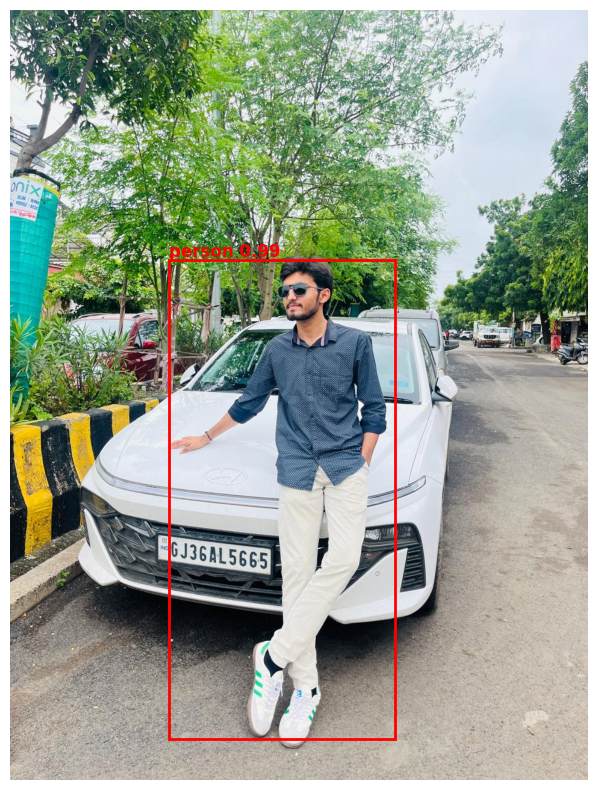

In [14]:
# =======================
# Cell8: Test on user input image (Human-only detection)
# =======================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import functional as F
import torchvision

def test_on_image(model, img_path, device="cuda", score_threshold=0.8, iou_threshold=0.4):
    """
    Detect humans only in an input image.

    Args:
        model: Trained detection model (e.g., Faster R-CNN)
        img_path: Path to input image
        device: "cuda" or "cpu"
        score_threshold: minimum confidence to keep a detection
        iou_threshold: NMS IoU threshold
    """
    model.eval()

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    # Apply NMS to clean overlapping boxes
    keep = torchvision.ops.nms(output["boxes"], output["scores"], iou_threshold)
    boxes = output["boxes"][keep]
    labels = output["labels"][keep]
    scores = output["scores"][keep]

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    detection_count = 0
    for box, label, score in zip(boxes, labels, scores):
        if label.item() == 1 and score.item() >= score_threshold:  # 1 = human in COCO
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor="r",
                facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(
                xmin,
                ymin - 5,
                f"person {score:.2f}",
                color="red",
                fontsize=12,
                weight="bold"
            )
            detection_count += 1

    plt.axis("off")
    plt.show()

    if detection_count == 0:
        print("No human detected in this image.")

# Example usage:
test_on_image(model, "/content/d.jpg", DEVICE)


In [12]:
from torchvision.ops import box_iou
import numpy as np

def evaluate_accuracy_strict(model, data_loader, device="cuda", iou_threshold=0.8, score_threshold=0.85):
    model.eval()
    total_images = 0
    correct_detections = 0

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            for output, target in zip(outputs, targets):
                total_images += 1
                gt_boxes = target["boxes"]
                pred_boxes = output["boxes"][output["scores"] > score_threshold]

                # Case 1: No humans in image, predicted none → correct
                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    correct_detections += 1
                    continue

                # Case 2: Humans present, check IoU match
                if len(gt_boxes) > 0 and len(pred_boxes) > 0:
                    iou_matrix = box_iou(gt_boxes, pred_boxes)
                    max_ious = iou_matrix.max(dim=1)[0]  # Best IoU for each ground truth box
                    # Strict rule: all ground-truth boxes must have IoU >= threshold
                    if (max_ious >= iou_threshold).all():
                        correct_detections += 1

    accuracy = (correct_detections / total_images) * 100
    print(f"Strict Validation Accuracy: {accuracy:.2f}%")
    return accuracy

# Run evaluation
val_accuracy = evaluate_accuracy_strict(model, val_loader, device=DEVICE)


Strict Validation Accuracy: 71.78%
